# Реализация логистической регрессии в TensorFlow

In [1]:
import numpy as np
import tensorflow as tf

/home/evgeny/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

## Генерируем данные для задачи регрессии

In [3]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

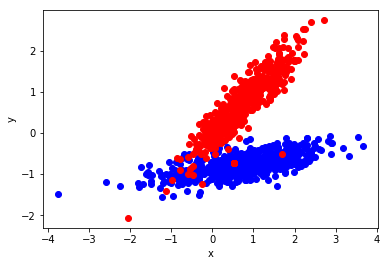

In [4]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

In [5]:
X.shape

(1000, 2)

## Вспомогательная функция для создания операций

In [6]:
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    
    name_prefix = ''.join(np.random.choice(list(string.ascii_letters), size = 10))
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной опреаций

In [7]:
def linear_op_forward(X, W, b):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T) + b  # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели: weights
    
    dX = tf.multiply(grads, W)
    dW = tf.reduce_mean(tf.multiply(X, grads),
                       axis = 0,
                       keep_dims = True)
    dB = tf.reduce_mean(grads, axis=0)
    return dX, dW, dB

def sigmoid_op_forward(X):
    # TODO: реализовать операцию sigmoid
    return 1 / (1 + np.exp(-X))

def sigmoid_op_backward(op, grads):
    # TODO: реализовать вычисление градиента для sigmoid
    X = op.inputs[0]
    dX = tf.multiply(grads, tf.nn.sigmoid(X) * (tf.ones_like(X) - tf.nn.sigmoid(X)))
    return dX

## Создание графа вычислений и обучение модели

In [8]:
BATCH_SIZE = NUM_SAMPLES // 10
print("batch_size: ", BATCH_SIZE)

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 54321))
    var_b = tf.Variable(tf.zeros(shape=[1, ], dtype=tf.float32))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W, var_b],     # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бмнарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.1).minimize(cost)   # i like it

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по 10-ти эпохам
    for epoch in range(20):
        
        # вначале каждой эпохи перемешиваем индексы
        np.random.shuffle(indices)
        
        # внутри каждой эпохи данные разбиваются на батчи
        for batch in range(len(X) // BATCH_SIZE):
            
            # выбираем индексы очередного батча
            batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

            # выполняем шаг обучения: вычисляем ошибку и обновляем веса
            loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                            plh_labels: y[batch_indices]})
        
            # сохраняем занчения ошибки для построения кривой обучения
            learning_curve.append(loss)
            
            # выводим текущее значение ошибки для каждого 10го шага
            steps = len(learning_curve) - 1
            if steps % 10 == 0:
                print('[%03d] loss=%.3f weights=%s bias=%s' % (steps, loss, var_W.eval(), var_b.eval()))
    
    # сохраняем обученные веса
    weights = var_W.eval()
    bias = var_b.eval()

batch_size:  100
Instructions for updating:
keep_dims is deprecated, use keepdims instead
[000] loss=0.754 weights=[[0.32768637 0.1598665 ]] bias=[-0.09989696]
[010] loss=0.650 weights=[[-0.42263195 -0.8174886 ]] bias=[-0.9259765]
[020] loss=0.656 weights=[[-0.01387602 -1.6530565 ]] bias=[-0.880582]
[030] loss=0.619 weights=[[ 0.6860739 -2.378851 ]] bias=[-0.7171623]
[040] loss=0.599 weights=[[ 0.94508034 -2.9916856 ]] bias=[-1.0615478]
[050] loss=0.525 weights=[[ 1.0436598 -3.4767613]] bias=[-1.50904]
[060] loss=0.549 weights=[[ 1.2248921 -3.8889303]] bias=[-1.6239518]
[070] loss=0.517 weights=[[ 1.3269849 -4.2352095]] bias=[-1.7404377]
[080] loss=0.534 weights=[[ 1.4298542 -4.531334 ]] bias=[-1.8384709]
[090] loss=0.563 weights=[[ 1.4673113 -4.794423 ]] bias=[-2.0042887]
[100] loss=0.522 weights=[[ 1.5398682 -5.0417576]] bias=[-2.0676033]
[110] loss=0.533 weights=[[ 1.5521172 -5.272737 ]] bias=[-2.139502]
[120] loss=0.531 weights=[[ 1.6117492 -5.4785447]] bias=[-2.275364]
[130] loss=

## Визуализируем кривую обучения

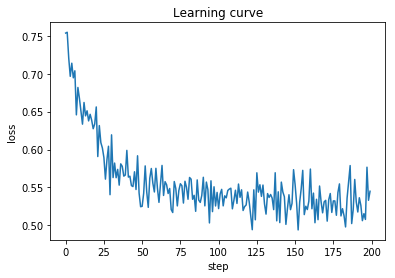

In [9]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем разделяющую гиперплоскость

In [10]:
weights

array([[ 1.922661 , -6.8442445]], dtype=float32)

In [11]:
bias

array([-2.853246], dtype=float32)

In [12]:
Z = []
for i in np.linspace(-4, 4):
    for j in np.linspace(-4, 4):
        Z.append([j, i])

In [13]:
Z = np.asarray(Z)
Z.shape

(2500, 2)

In [14]:
X_,Y_ = np.meshgrid(np.linspace(-4, 4),np.linspace(-4, 4))
# Z_ = np.asarray([i for i in range(X.shape[0]*X.shape[1])]).reshape(X.shape[0],X.shape[1])
Z_ = (np.dot(Z, weights.T) + bias).reshape((X_.shape[0], X_.shape[1]))

In [15]:
Z_

array([[ 16.83308816,  17.14699199,  17.46089582, ...,  31.58656808,
         31.90047191,  32.21437573],
       [ 15.71566049,  16.02956432,  16.34346815, ...,  30.46914041,
         30.78304424,  31.09694806],
       [ 14.59823282,  14.91213665,  15.22604048, ...,  29.35171274,
         29.66561657,  29.97952039],
       ...,
       [-35.68601234, -35.37210851, -35.05820468, ..., -20.93253242,
        -20.61862859, -20.30472477],
       [-36.80344001, -36.48953618, -36.17563236, ..., -22.04996009,
        -21.73605626, -21.42215244],
       [-37.92086768, -37.60696385, -37.29306003, ..., -23.16738776,
        -22.85348393, -22.53958011]])

In [16]:
X_.shape, Y_.shape, Z_.shape

((50, 50), (50, 50), (50, 50))

Разделяющая поверхность

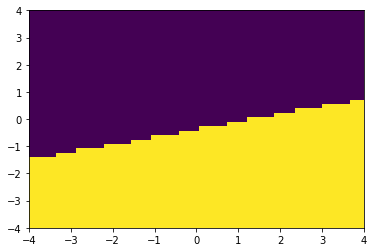

In [17]:
plt.pcolormesh(X_,Y_,Z_>0)

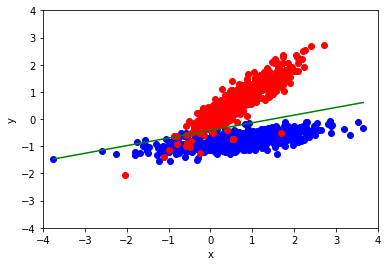

In [19]:
y_pred = (-bias - weights[0, 0] * X[:, 0]) / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');